### Домашнее задание. День 5: CVXPY

- Выполняйте работу в этом же ноутбуке

- Рекомендуется использовать темную тему в ноутбуке

- В некоторых заданиях вам даны ассерты для проверки правильности кода


In [1]:
import numpy as np
import cvxpy as cp
import scipy

$\color{orange} \text{Задание 1.} $ Дана некая матрица $B = x_1A_1 + x_2A_2 + ... + x_n A_n$. То есть, матрица $B$ - линейная комбинация матриц $A_i$. В этом задании мы попробуем решить задачу поиска коэфициентов $x_i$ используя библиотеку CVXPY. \
Пусть $A,B \in R^{\,p \times q}, n = 6, p = 10, q = 30$\
Вам нужно:
1. Сформулировать задачу как задачу минимизации
3. Решить сгенерированную нами задачу, используя библиотеку CVXPY, вывести и проверить ответ
4. Добавить ограничение: $||x||_2<=3$. Решить ту же задачу, что раньше, но с новым ограничением. Вывести и проверить ответ

In [4]:
n = 6
p = 10
q = 30
A_i = []
for i in range(n):
    A_i.append(np.random.randn(p, q))

B = np.zeros((p, q))
for i in range(n):
    B += (np.random.rand()*6-3) * A_i[i]

In [ ]:
# Ваш код тут

$\color{orange} \text{Задание 2.}$ Рассмотрим задачу максимального разреза графа. Дан связный ненаправленный граф с $N$ вершинами. Между некоторыми вершинами имеется ребро заданного веса $w_{ij}$. __Задача__: распределить вершины на две группы так, чтобы максимизировать сумму весов всех ребер, которые соединяют вершины в разных группах (одна вершина в группе А, другая вершина в группе Б)

Эта задача имеет довольно большое число различных применений на практике. \
Один из очень простых игрушечных примеров для понимания сути: предположим есть набор компьютеров. Некоторые из них имеют друг с другом связь (по проводу или беспроводу), другие нет. \
У нас есть две разные задачи, под которые мы хотим распределить компьютеры (и работающих за ними людей). Задачи связаны, так что обе группы компьютеров должны иметь связь друг с другом. Всякое бывает, и связь между 2 (а может и больше) компьютерами (любыми) может пропасть. \
Наша задача разделить компьютеры на эти группы так, чтобы минимизировать риски от пропажи связи между случайными компьютерами. \
Как решение, мы можем присвоить вес 1 всем ребрам, и решить задачу максимального разреза графа. Так как вес всех ребер равен 1, то задача реформулируется так: разделить компьютеры на 2 группы так, чтобы максимизировать число ребер (ведь сумма весов равна сумме ребер в нашем случае) между компьютерами в разных группах. Как раз то, что нам нужно. Интуитивно ясно, что чем больше соединений между группами, тем меньше шанс остаться без связи между группами

На рисунке можно посмотреть пример максимального разреза, когда у каждого ребра вес 1. То есть, мы максимизируем суммарное число ребер из вершин одного набора в вершины другого набора

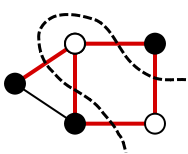

Будем работать с графом $G = (V, E)$, где $V$ - множество вершин, $E$ - множество ребер. $N$ - число вершин.\
 $w_{ij}$ - вес ребра $(i,j) \in E$. 0, если ребра нет\
 $S, \hat{S}$ - непересекающиеся множества вершин в первой и второй группах.\
 $x_i  = \left\{ \begin{array}{cl} 1 & : \ x_i \in S \\-1 & : \ x_i \in \hat{S}\end{array} \right.$\
 То есть $x_i$ показывает, в какой из двух групп находится вершина. Эту переменную (вектор) мы и хотим найти

Наша задача может быть записана как задача целочисленного квадратичного программирования:
$$
\begin{align*}
& \max_x \frac{1}{2} \sum_{i}^{N} \sum_{j}^{N} w_{ij} \frac{(1-x_i x_j)}{2} \\
& \text{s.t. } x_i \in \{1, -1\}, \forall i \in V
\end{align*}
$$


$\frac{(1-x_i x_j)}{2}$ равно единице только когда обе вершины находятся в разных группах, в противном случае 0. Поэтому мы максимизируем как раз сумму весов тех ребер, что соединяют вершины из разных групп. Деление на два происходит из-за того, что каждое ребро считается два раза.

Основная проблема заключается в том, что без модификаций это NP-трудная задача, для которой не известен алгоритм решения за полиномиальное время. Для их решения, обычно проводится релаксация (изменение) условия таким образом, что бы получилась новая NP-полная задача (для которой известен алгоритм решения за полиномиальное время), решение которой близко к настоящему решению

Конкретнее, предположим что $c_{optimal}$ - это значение целевой функции при решении изначальной задачи любым алгоритмом. Назовем некий алгоритм $\delta$-приблизительным, если он выдает оптимальное значение целевой функции $c_{approximate} \ge \delta c_{optimal}$. Чем ближе $\delta$ к 1, тем лучше. К примеру, алгоритм, который случайно делит вершины графа на две группы, является 0.5-приблизительным. Мы же выведем 0.875-приблизительный алгоритм.

Для этого, мы сведем оригинальную задачу целочисленного квадратичного программирования к такой задаче, которую мы знаем как решать (удостоверившись, что решение этой задачи не даст решение оптимальнее, чем настоящее, что логично), путем релаксации.

Мы сделаем релаксацию к задаче полуопределенного программирования, которая в общем виде задается следующим образом:
$$
\begin{align*}
& \min_X \langle C, X \rangle \\
& \text{s.t. } \langle A_i, X \rangle \le b_i, \forall i \in V \\
& X \succeq 0
\end{align*}
$$

где $\langle A, B \rangle = \sum_{i,j}^{N} A_{ij} B_{ij}$\
Вместо неравенства в условиях может быть и равенство. Эту задачу можно написать по-разному, мы же будем использовать эту форму

Идейно, если в задаче линейного программирования мы оптимизируем линейную функцию на выпуклом многограннике, то в задаче полуопределенного программирования мы оптимизируем так же линейную функцию на выпуклой фигуре, но теперь это более сложная фигура, а не многогранник. Ниже можно посмотреть на пример. Заметим, что задача полуопределенного программирования - это задача линейного программирования с бесконечным числом линейных ограничений

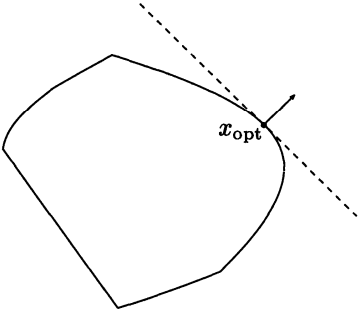

$\color{lime} \text{Подзадание 1.}$ Сейчас у нас в условии некая квадратичная функция от $x$, которую нам нужно свести к линейной функции. Уйдем от чисел $x_i$ (равных по модулю единице) к единичным векторам $u_i \in \mathbb{R}^N$. 

Интуиция следующая: до этого мы скаляром отмечали, к какому набору принадлежит вершина. Теперь, мы это делаем единичным вектором. И ставим задачу максимизировать расстояние между конечными точками эти векторов, если точки лежат в разных наборах. Если же вершины в одном наборе, тогда их вектора должна указывать в примерно одно место 

Запишите исходную задачу с новыми условиями и переменными. Распишите, откуда взялись те или иные новые условия

$\color{violet}\text{Ваше решение тут}$

$\color{lime} \text{Подзадание 2.}$ Теперь, сделаем из квадратичной функции линейную. Введите $Y_{i,j} = u_i ^\top u_j$, перепишите задачу из предыдущего пункта с новыми условиями.\
Сделайте так, чтобы условия (не целевая функция) выглядели уже как в шаблоне для задачи полуопределенного программирования. \
Распишите, откуда взялись те или иные новые условия

$\color{violet}\text{Ваше решение тут}$

$\color{lime} \text{Подзадание 3.}$ Осталось целевую функцию представить в виде внутреннего произведения матриц, как в шаблоне. Распишите вашу целевую функцию в виде ... + ..., и подумайте как эту сумму превратить во внутреннее произведение матриц.

Подсказка: внутреннее произведение $\sum_{i,j}^{N} A_{ij} B_{ij} $ суммирует поэлементное произведение двух матриц. Это можно сделать сначала по диагонали, потом по оставшимся элементам, а потом сложить. К подобной сумме вам и стоит попробовать привести исходную сумму

$\color{violet}\text{Ваше решение тут}$

$\color{lime} \text{Подзадание 4.}$ Ниже вам задана матрица весов $W$. Вам нужно решить для $Y$ задачу, сформулированную вами выше в подзадача 2 или 3, используя CVXPY. Вы можете формулировать задачу в коде как вам удобно (упрощать матричные умножения, и так далее), __объяснив все изменения__. 

In [2]:
W = np.array([[0, 4, 10, -3, 0, 0, 0], [4, 0, 0, 0, 6, 0, 0], [10, 0, 0, 7, 0, 0, 0], [-3, 0, 7, 0, 0, 0, 8], [0, 6, 0, 0, 0, 4, 0], [0, 0,0,0,4,0,1],[0, 0, 0, 8, 0, 1, 0]], dtype = np.float32)
n = 7

In [ ]:
# Ваш код тут
Y = ... 
constraints = []

cost = ...
problem = ...
optimal_value = problem.solve()

In [ ]:
assert abs(optimal_value - 39) < 1e-2, "Правильный ответ - 39, ваше же ему не равно"

$\color{lime} \text{Подзадание 5.} $ Мы получили решение для $Y$. Однако, нужно то нам узнать значения $x_i$. Начнем идти в обратном порядке. Используя наше определение матрицы $Y$, запишите $Y$ как произведение двух матриц (назовем их $A, B$), предложите способ из __только__ матрицы $Y$ получить $A, B$. Напишите соответствующий код.

$\color{violet}\text{Ваше решение тут}$

In [1]:
# ваш код тут

$\color{lime} \text{Подзадание 6.}$ Одна из полученных вами матриц является матрицей, у которой строка $i$ равна $u_i$ - единичному вектору, который олицетворяет принадлежность точку тому или иному набору. Нам нужно этот вектор превратить в циферку - 1 или -1. Наша модель обучена так, что вершины из разных наборов имеют "разные" векторные репрезентации, которые находятся в разных частях единичной сферы. Мы воспользуемся следующим приемом (называется __randomized hyperplane rounding__): сгенерируем __случайную__ плоскость (разберитесь, как правильно это делать) и поделим точки на единичной сфере на 2 набора в зависимости от того, по какую сторону эти точки оказались относительно сгенерированной плоскости. Мы полагаем, что если две точки находятся в разных частях сферы, то скорее всего при создании случайной плоскости через центр сферы эти точки окажутся по разные стороны. 

Вам нужно найти способ сгенерировать случайную гиперплоскость и разделить вершины на два набора. У вас должны получится два списка __чисел__: S и S_bar. В обоих - номера вершин в этих наборах, нумерация с нуля.\
Вы должны пройти ассерт в конце

In [5]:
S = []
S_bar = []
# ваш код тут

In [7]:
# Проверка деления
def calculate_cut(S, S_bar, W):
    max_cut = 0
    for i in S:
        for j in S_bar:
            max_cut += W[i][j]
    return max_cut

assert abs(calculate_cut(S, S_bar, W) - 39) < 1e-2, "Правильный ответ - 39, ваша разбивка этот ответ не дает"